In [1]:
from spectacle.core.spectra import Spectrum1D
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from spectacle.modeling.fitting import Fitter
from astropy.modeling.models import Linear1D
from spectacle.core.models import Voigt1D

In [2]:
%matplotlib inline

# Identify and parameterize real data
This is an example notebook of taking some real data and fitting an absorption feature. It is very basic, and uses all the default settings.

## Load data
Load the data. The fitter currently assumes that all data has been normalized to 1.

In [3]:
# Load real data
hdulist = fits.open("/Users/nearl/projects/hst_proposal/QSOALS/3C066A/3C066A_coadd_FUVM_final_all.fits")
disp, flux, uncert = hdulist[1].data['WAVE'], hdulist[1].data['FLUX'], \
                     hdulist[1].data['ERROR']

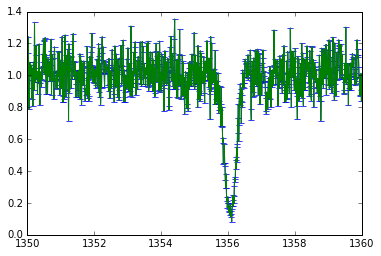

In [4]:
# Create a mask and apply it since we don't really care about the entire spectrum
mask = [(disp > 1350) & (disp < 1360)]
flux = flux[mask]
disp = disp[mask]
uncert = uncert[mask]

# Currently, the fitting assumes that the data is normalized to 1.0
flux /= np.median(flux)
uncert /= np.median(flux)

# Create spectrum object
spectrum = Spectrum1D(disp, flux, uncertainty=uncert)

# Plot the spectrum
plt.errorbar(spectrum.dispersion, spectrum.flux, yerr=spectrum.uncertainty)
plt.plot(spectrum.dispersion, spectrum.flux)

## Create `Fitter`
The `Fitter` object encapsulates the method of fitting, along with the line identifying and detrending routines. Certain parameters, like the distance between identified lines, and the noise level can also be set.

Found 1 peaks
Finished applying lines
   Parameter       Original Value     Fitted Value     Uncertainty   
---------------- ----------------- ----------------- ----------------
         slope_0               0.0               0.0              0.0
     intercept_0               1.0               1.0              0.0
      lambda_0_1     1356.10697068     1356.06385871 0.00443341911826
       f_value_1               0.5    0.291748670333    1550051.95692
         gamma_1               0.0            5560.0              0.0
     v_doppler_1        10000000.0      4315272.5685    113147.054603
column_density_1 9.17546587976e+13 1.37471186099e+14 7.3261673059e+20


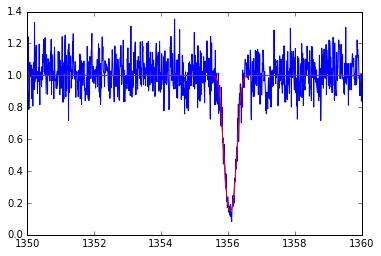

In [5]:
# Create a fitter. The default fitting routine is a LevMarLSQ.
fitter = Fitter()
result_spectrum = fitter(spectrum)
print(fitter.fit_info)

# Plot the fitted spectrum with the original
plt.plot(spectrum.dispersion, spectrum.flux)
plt.plot(result_spectrum.dispersion, result_spectrum.flux, color='red')